# Лабораторная работа 1

## Задание 1

### Задание 1.1

Задана плотность распределения вероятностей некоторой случайной величины:  
$𝑓(𝑥) = (1/4𝜋) * (2 + cos 𝑥)* 𝐼(0 ≤ 𝑥 ≤ 2𝜋)$,
где 𝐼(𝑥 ∈ 𝐴) = 1, если 𝑥 ∈ 𝐴 и нуль иначе.  
  
Нужно сгенерировать выборку из данного распределения. На основе сгенерированной выборки проверить гипотезу согласия с заданным распределением.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest


def I(x: float):
    return np.logical_and(0 <= x, x <= 2 * np.pi)

# плотность распределения
def f(x):
    return (1 / (4 * np.pi)) * (2 + np.cos(x)) * I(x)

# теоретическая функция распределения
def F(x):
    return (1 / (4 * np.pi)) * (2 * x + np.sin(x)) * I(x)

In [3]:
def generate_sample(size):
    sample = []
    M = 3 / (4 * np.pi)
    # M = 0.4
    while len(sample) < size:
        x1 = np.random.uniform(0, 2 * np.pi)
        x2 = np.random.uniform(0, M)
        if x2 <= f(x1):
            sample.append(x1)
    return np.array(sample)

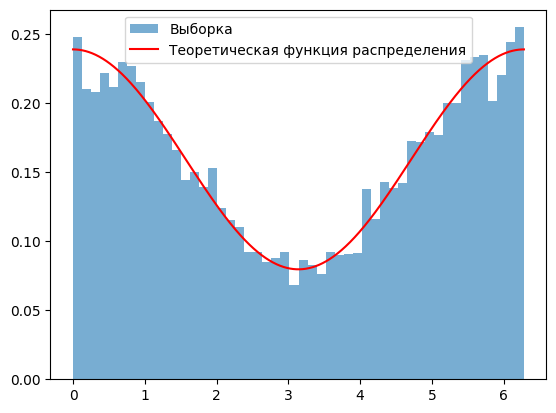

In [4]:
# генерация выборки
sample_size = 10000
sample = generate_sample(sample_size)

# график
plt.hist(sample, bins=50, density=True, alpha=0.6, label='Выборка')
x_vals = np.linspace(0, 2 * np.pi, 1000)
plt.plot(x_vals, f(x_vals), 'r-', label='Теоретическая функция распределения')
plt.legend()
plt.show()

In [5]:
# проверка гипотезы согласия
D, p_value = kstest(sample, F)

print(f"Статистика Колмогорова-Смирнова: D = {D:.10f}")
print(f"p-value: {p_value:.10f}")

Статистика Колмогорова-Смирнова: D = 0.0105287702
p-value: 0.2160505220


Значение p-value больше выбранного уровня значимости 0.05 (уровень доверия 95%). Гипотеза согласия не отвергается, и имеются веские основания полагать, что выборка соответствует заданному распределению.

P-value - вероятность получить такое значение статистики для данной модели, при условии, что гипотеза верна. Если p-value больше уровня значимости, то вероятность получить такое значение достаточно велика, чтобы предполагать, что наша гипотеза верная.

Уровень значимости - величина, используемая для оценки истинности критерия. Очень грубо говоря это вероятность события, которое мы называем статистическим критерием, при условии верности гипотезы. 

Уровень доверия - вероятность того, что значение случайной величины находится в доверительном интервале. Доверительный интервал - интервал с такими границами, что значения случайной величины находятся в пределах этого интервала с заданной вероятностью.

### Задание 1.2

Пусть случайный вектор 𝑋 = (𝑋1, ..., 𝑋𝑛) имеет многомерное нормальное распределение N(𝜇, Σ) (вектор средних 𝜇 и матрица ковариаций Σ заданы).  
  
На основе сгенерированной выборки найти оценку матрицы ковариаций и проверить гипотезу о равенстве коэффициента корреляции 𝐶𝑜𝑟(𝑋𝑖
, 𝑋𝑗) (для фиксированных индексов 𝑖, 𝑗 = 1, ..., 𝑛) требуемому значению.

In [6]:
import numpy as np

# параметры распределения
a = np.array([1, 2, 3])  # вектор средних = матожидания
sigma = np.array([[1,   0.5,   0.25],
                  [0.5,   2,   0.75],
                  [0.25, 0.75, 3]]) # матрица ковариаций

# генерация выборки
sample_size = 1000
X = np.random.multivariate_normal(a, sigma, sample_size)

In [7]:
print(X)

[[1.36367129 1.83184897 5.62306318]
 [0.65876867 1.63745145 4.73162768]
 [1.07083304 2.31986209 8.25600461]
 ...
 [2.96984154 2.4497323  1.75098623]
 [1.08760076 0.53124516 1.81712386]
 [2.43476492 4.43400304 4.69458019]]


In [8]:
# оценка матрицы ковариаций
sigma_est = np.cov(X, rowvar=False)
print("оценка матрицы ковариаций:\n", sigma_est)

оценка матрицы ковариаций:
 [[0.95674341 0.4895542  0.22741978]
 [0.4895542  1.97549461 0.68174005]
 [0.22741978 0.68174005 3.05939535]]


In [9]:
from scipy.stats import norm

i, j = 0, 1

# выборочный коэффициент корреляции.
r = sigma_est[i][j] / np.sqrt(sigma_est[i][i] * sigma_est[j][j])
print(r)

# теоретический коэффициент корреляции.
# ну, будем считать что p это ро...
p = sigma[i][j] / np.sqrt(sigma[i][i] * sigma[j][j])
print(p)

# выполним Z-преобразование Фишера, чтобы приблизить распределение r к нормальному.
z_r = np.log((1 + r) / (1 - r)) / 2
z_p = np.log((1 + p) / (1 - p)) / 2

# статистика для проверки гипотезы. имеет норм. распр. N(0,1), если гипотеза верна.
n = sample_size
t = (z_r - z_p) / np.sqrt(1 / (n - 3))

# критическое значение для уровня значимости 5%
a = 0.05
t_crit = norm.ppf(1 - a) # квантиль станд. норм. распр. для 0.95

p_value = 2 * (1 - norm.cdf(np.abs(t)))

print(f"p_value = {p_value}")

if abs(t) < t_crit:
 print(f"Нет оснований отвергнуть гипотезу |t| < t_кр")
 print(f"{abs(t)} < {t_crit}")
else:
 print(f"Гипотеза отклоняется  |t| >= t_кр")
 print(f"{abs(t)} > {t_crit}")

0.3560943745478631
0.35355339059327373
p_value = 0.9268659931566148
Нет оснований отвергнуть гипотезу |t| < t_кр
0.09178861076052194 < 1.644853626951472


## Задание 2

Заданы координаты вершин двух треугольников (на плоскости). С помощью метода Монте-Карло вычислить площадь их пересечения.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def vector_product(a, b, c):
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

def point_in_triangle(p, a, b, c):
    d1 = vector_product(p, a, b)
    d2 = vector_product(p, b, c)
    d3 = vector_product(p, c, a)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)

In [11]:
def monte_carlo_area_intersection(A, B, x_min, y_min, x_max, y_max):
    # параметры метода Монте-Карло
    N = 2000
    points_in_intersection = 0

    for _ in range(N):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        p = (x, y)
        if point_in_triangle(p, A[0], A[1], A[2]) and point_in_triangle(p, B[0], B[1], B[2]):
            points_in_intersection += 1

    # оценка площади пересечения
    rectangle_area = (x_max - x_min) * (y_max - y_min)
    intersection_area = (points_in_intersection / N) * rectangle_area

    print(f"Площадь пересечения: {intersection_area:.4f}")

    # визуализация треугольников
    fig, ax = plt.subplots()
    ax.add_patch(Polygon(A, fill=None, edgecolor='blue', label='Треугольник A'))
    ax.add_patch(Polygon(B, fill=None, edgecolor='red', label='Треугольник B'))

    # визуализация случайных точек
    x_points = np.random.uniform(x_min, x_max, N)
    y_points = np.random.uniform(y_min, y_max, N)
    colors = ['green' if point_in_triangle((x, y), A[0], A[1], A[2]) and point_in_triangle((x, y), B[0], B[1], B[2]) else 'gray' for x, y in zip(x_points, y_points)]
    ax.scatter(x_points, y_points, c=colors, s=4, alpha=1.0)

    # настройка графика
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.legend()
    plt.show()

Площадь пересечения: 1.8080


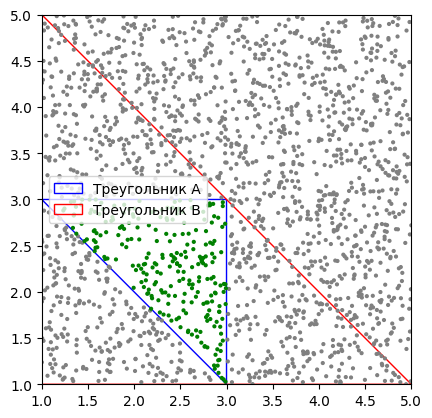

In [12]:
# координаты вершин треугольников
A = [(3, 3), (1, 3), (3, 1)]
B = [(1, 1), (1, 5), (5, 1)]

# ограничивающий прямоугольник
x_coords = [p[0] for p in A + B]
y_coords = [p[1] for p in A + B]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

monte_carlo_area_intersection(A, B, x_min, y_min, x_max, y_max)

## Задание 3

Портфель составлен из ценных бумаг 𝑚 различных видов. Предполагается, что стоимость ценной бумаги вида 𝑖 = 1, ..., 𝑚 изменяется в соответствии с геометрическим броуновским движением:  
$$S_T^i=S_0^i e^{\left(\mu_i-\sigma_i^2 / 2\right) T+\sigma_i \sqrt{T} Z_i}, Z_i \sim \mathcal{N}(0,1)$$

Случайные процессы $S^i$, 𝑖 = 1, ..., 𝑚 предполагаются независимыми. Общая стоимость портфеля в момент времени 𝑡 равна  
$V_t=\sum_{i=1}^m n_i S_t^i$, где $n_i$ – число ценных бумаг вида 𝑖.

Обозначим разницу в стоимости портфеля $𝐿_𝑇 = 𝑉_0 − 𝑉_𝑇$. Требуется найти стоимостную меру риска (VaR - Value at Risk)  
$V a R_\alpha=\sup \left\{u \in \mathbb{R}: \mathbb{P}\left(L_T \geq u\right) \geq 1-\alpha\right\}$, где 1 − 𝛼 – уровень доверия

$S_T^i$ - цена в момент времени T

$S_0^i$ - начальная цена

$\mu_i$ - доходность

$\sigma_i$ - волатильность (дисперсия цены)

$Z_i$ - случайная величина с нормальным распределением

In [13]:
import numpy as np

# параметры портфеля
m = 3  # количество видов ценных бумаг
n = np.array([10, 20, 30])  # количество ценных бумаг каждого вида
S0 = np.array([100, 50, 80])  # начальные стоимости ценных бумаг
mu = np.array([0.05, 0.03, 0.04])  # ожидаемые доходности
sigma = np.array([0.2, 0.15, 0.25])  # волатильности
T = 1  # временной горизонт (1 год)

alpha = 0.05 # уровень доверия (1 - alpha)
N = 100000 # количество сценариев Монте-Карло

V0 = np.sum(n * S0) # начальная стоимость портфеля

# моделирование будущих стоимостей ценных бумаг и убытков
losses = np.zeros(N)
for i in range(N):
    Z = np.random.normal(0, 1, m) # генерация случайных величин Z_i ~ N(0, 1)
    ST = S0 * np.exp((mu - sigma**2 / 2) * T + sigma * np.sqrt(T) * Z) # моделирование будущих стоимостей S_T^i
    VT = np.sum(n * ST) # стоимость портфеля в момент T
    losses[i] = V0 - VT # убыток

# вычисление VaR_alpha
VaR_alpha = np.quantile(losses, 1 - alpha)
# квантиль - значение, которое величина не превышает с вероятностью 1-alpha
print(f"VaR_{alpha}: {VaR_alpha:.2f}")

VaR_0.05: 822.02


## Задание 4

В области 𝐴, представляющей собой бесконечный слой (на плоскости) вакуума толщиной 𝐷 м, было одновременно испущено 𝑁+1 фотонов, где 𝑁 – случайная величина, имеющая распределение Пуассона с параметром 𝜆 = 2. Предполагается, что точки излучения расположены на одной прямой и их распределение по толщине 𝐷 равномерное, а распределение направлений излучения фотонов – изотропное. С каждой из двух сторон расположен детектор в виде бесконечной полосы. При попадании в детектор фотон поглощается. Детекторы включены в схему совпадений, которая срабатывает в том случае, если промежуток времени между попаданиями фотонов в детекторы не превышает ∆𝑡 = 3 · 10^−8 с. Скорость света в вакууме 𝐶 = 3 · 10^8 м/с. Вычислить вероятность того, что схема сработала.

In [14]:
import numpy as np

# параметры задачи
D = 1  # толщина слоя (м)
C = 3e8  # скорость света (м/с)
Delta_t = 3e-8  # временной интервал для срабатывания схемы (с)
lambda_poisson = 2  # параметр распределения Пуассона для количества фотонов
k = 10000 # количество симуляций
success_count = 0

for _ in range(k):
    N = np.random.poisson(lambda_poisson) # считаем N
    total_photons = N + 1 
    x = np.random.uniform(0, D, total_photons) # равномерно раскидываем точки начала
    theta = np.random.uniform(0, 2 * np.pi, total_photons) # и углы под которыми полетят фотоны

    t = np.zeros(total_photons) # времена
    for i in range(total_photons):
        if np.cos(theta[i]) > 0:
            # фотон движется в сторону правого детектора (x = D)
            t[i] = (D - x[i]) / (C * np.cos(theta[i]))
        else:
            # фотон движется в сторону левого детектора (x = 0)
            t[i] = x[i] / (C * np.abs(np.cos(theta[i])))

    # проверка срабатывания схемы совпадений
    scheme_triggered = False 
    t = sorted(t) # сортируем времена по возрастанию
    for i in range(0, total_photons - 1):
        # проверяем, что фотоны попали в детекторы почти одновременно
        if np.abs(t[i] - t[i + 1]) <= Delta_t:
            scheme_triggered = True  # схема сработала
            break

    # увеличиваем счетчик успешных срабатываний
    if scheme_triggered:
        success_count += 1

probability = success_count / k # сколько раз из всех симуляций сработала схема
print(f"Вероятность срабатывания схемы: {probability:.6f}")

Вероятность срабатывания схемы: 0.849900


## Задание 5

Реализовать алгоритм генерации точек, равномерно распределенных на поверхности геликоида:
$$
\left\{
\begin{array}{l}
x = u \cos v, \\
y = u \sin v, \\
z = v
\end{array}
\right.
\quad 0 \leq u, v \leq 2 \pi
$$

Если сделаем просто равномерное распределение по u, v, то координаты на выходе будут не равномерными, а сгущенными у центра, поскольку u это радиус, и площадь фигуры в радиальной системе координат от него зависит. поэтому делаем масштабирование с помощью корня из нормального распределения.

method of inverse transform sampling:

- Если хотим получить случайную величину с плотностью $p(u) \propto u$, то:
  - сначала интегрируем плотность:
    $$F(u) \propto \int_0^u x\, dx = \frac{u^2}{2}$$
  - берём равномерную случайную величину $U \sim \mathcal{U}(0,1)$
  - приравниваем $F(u) = U$ и решаем относительно $u$

$$F(u) = \frac{u^2}{R^2} = U \quad \Rightarrow \quad u = R \sqrt{U}$$

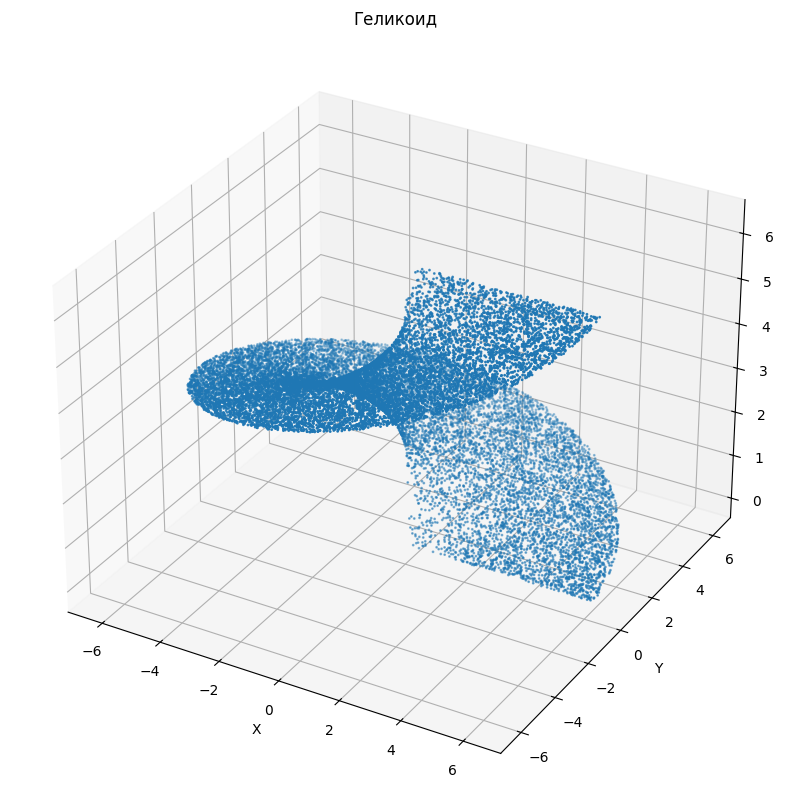

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def generate_helicoid_points(n_points=20000):
    # генерируем равномерно распределенные точки в пространстве
    # используем преобразование для равномерного распределения на спирали
    u = np.sqrt(np.random.uniform(0, 1, n_points)) * (2 * np.pi) # радиальная координата (расстояние от оси z)
    v = np.random.uniform(0, 1, n_points) * (2 * np.pi) # угловая координата (угол поворота вокруг оси z)

    # если не преобразовывать, то будет не равномерно
    # u = np.random.uniform(0, 2*np.pi, n_points)
    # v = np.random.uniform(0, 2*np.pi, n_points)

    # вычисляем координаты
    x = u * np.cos(v)
    y = u * np.sin(v)
    z = v
    
    # собираем результат в единый массив
    points = np.column_stack((x, y, z))
    
    return points

# визуализация
def plot_helicoid(points):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # точки
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    
    # оси
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Геликоид')
    
    plt.show()

# генерируем
points = generate_helicoid_points(20000)

# показываем
plot_helicoid(points)

$$\begin{cases} x= x(u,v), \\ y= y(u,v),  \\ z= z(u,v),\end{cases}$$

Требуется найти совместную плотность распределения параметров $(u,v)$, соответствующую равномерному распределению точек на рассматриваемой поверхности. Вероятность попадания произвольной точки A в элемент поверхности dS равна
$$P(A \in dS) = \frac{dS}{S} = \frac{\sqrt{EG - F^2}dudv}{\underset{D}{\iint}\sqrt{EG - F^2}dudv} = f(u,\ v)dudv,$$
где
$$E = x_u^2 + y_u^2 + z_u^2,\ G = x_v^2 + y_v^2 + z_v^2,\ F = x_ux_v + y_uy_v + z_uz_v$$

Таким образом,
$$f(u,\ v) = \frac{\sqrt{EG - F^2}}{\underset{D}{\iint} \sqrt{EG - F^2}dudv},$$
где
$$E = x_u^2 + y_u^2 + z_u^2,\ G = x_v^2 + y_v^2 + z_v^2,\ F = x_ux_v + y_uy_v + z_uz_v$$
Если $D = \{(u,\ v):u_1 \le u \le u_2; v_1 \le v \le v_2\}$, то для моделирования двумерной случайной величины $(u,\ v)$ можно воспользоваться методом Неймана.